In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

# hyper parameters
batch_size = 64
latent_dim = 10
epochs = 15

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# MNIST data set
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# filter to only get 2 for instance
# indices_label_1 = (train_dataset.targets == 4).nonzero(as_tuple=True)[0]
# indices_label_2 = (train_dataset.targets == 5).nonzero(as_tuple=True)[0]

# combine labels 4 & 5 for instance
# combined_indices = torch.cat((indices_label_1, indices_label_2))
# train_dataset.data = train_dataset.data[combined_indices]
# train_dataset.targets = train_dataset.targets[combined_indices]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, latent_dim),
            nn.LeakyReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(batch_size, 1, 28, 28)
        # x = self.convoluter(x)
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x



autoencoder = Autoencoder()
criterion = nn.MSELoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

counter = 0

# training
for epoch in range(epochs):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = autoencoder(inputs)
        # inputs.view(inputs.size(0), -1)
        outputs2 = autoencoder.encoder(inputs.view(inputs.size(0), -1))
        # label loss cirterion labels und outputs2 haben unterschiedliche dim
        labels_t = F.one_hot(labels, num_classes=latent_dim)
        labels_t = labels_t.to(torch.float)
        loss2 = criterion2(outputs2, labels_t)

        # one_hot_labels = F.one_hot(labels, num_classes=10)
        loss1 = criterion(outputs, inputs.view(-1, 28 * 28))
        loss = loss1 * 0.5 + loss2 * 20
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

# generate image
import matplotlib.pyplot as plt

with torch.no_grad():
    noise = torch.randn(1, latent_dim)
    generated_image = autoencoder.decoder(noise).view(28, 28).cpu().numpy()




Epoch [1/15], Loss: 0.8380
Epoch [2/15], Loss: 0.5400
Epoch [3/15], Loss: 0.6199
Epoch [4/15], Loss: 0.5921
Epoch [5/15], Loss: 0.6873
Epoch [6/15], Loss: 0.6684
Epoch [7/15], Loss: 0.7189
Epoch [8/15], Loss: 0.5053
Epoch [9/15], Loss: 0.5032
Epoch [10/15], Loss: 0.6965
Epoch [11/15], Loss: 0.5311
Epoch [12/15], Loss: 0.5703
Epoch [13/15], Loss: 0.5943
Epoch [14/15], Loss: 0.5277
Epoch [15/15], Loss: 0.4946


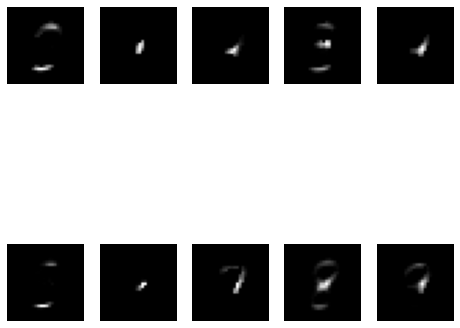

In [6]:
images2 = []

for i in range(10):
    with torch.no_grad():
        number = F.one_hot(torch.tensor([i]), num_classes=latent_dim)
        number = number.to(torch.float)
        number *= 0.75
        generated_image = autoencoder.decoder(number).view(28, 28).cpu().numpy()
        images2.append(generated_image)
        
plt.figure(figsize=(8, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images2[i], cmap='gray')
    plt.axis('off')

plt.show()

## Test more sophisticated model

In [289]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')


batch_size = 64
latent_dim = 10
epochs = 8

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

indices_label_1 = (train_dataset.targets == 4).nonzero(as_tuple=True)[0]
indices_label_2 = (train_dataset.targets == 3).nonzero(as_tuple=True)[0]

train_dataset.data = train_dataset.data[indices_label_2] # alt combined_indices
train_dataset.targets = train_dataset.targets[indices_label_2]
# train_dataset.targets = train_dataset.targets[combined_indices]

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)




class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool3d((4, 2, 2)),
            nn.Flatten(),
            # 28/2 = 14 /2 = 7 
            nn.Linear(7 * 7, 32),
            nn.LeakyReLU(),
            nn.Linear(32, latent_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (1, 2, 5)),
            nn.ConvTranspose2d(1, 2, 2, stride=(2,3), padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(2, 4, 2, stride=(2,3), padding=1), #6x33x4
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Linear(4 * 33 * 2, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


autoencoder = Autoencoder()
criterion = nn.MSELoss()
criterion2 = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

counter = 0

# training
for epoch in range(epochs):
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        
        outputs = autoencoder(inputs)
        loss1 = criterion(outputs, inputs)
        
        latent_vec = autoencoder.encoder(inputs)
        labels_t = F.one_hot(labels, num_classes=latent_dim)
        labels_t = labels_t.to(torch.float)
        loss2 = criterion2(latent_vec, labels_t)
        loss = loss1 * 0.5 + loss2 * 20
        
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Running on the CPU
Epoch [1/8], Loss: 0.4573
Epoch [2/8], Loss: 0.4558
Epoch [3/8], Loss: 0.4545
Epoch [4/8], Loss: 0.4538
Epoch [5/8], Loss: 0.4542
Epoch [6/8], Loss: 0.4525
Epoch [7/8], Loss: 0.4551
Epoch [8/8], Loss: 0.4580


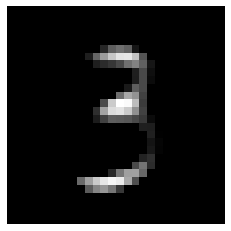

In [290]:
import matplotlib.pyplot as plt

with torch.no_grad():
    noise = torch.randn(1, 10)
    generated_image = autoencoder.decoder(noise).squeeze().cpu().numpy()

plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()

## Generate new combinations of number profiles

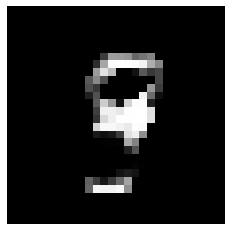

In [281]:
with torch.no_grad():
    tensor_value = torch.tensor([[-0.25, -0.25, -0.25, 1, -0.25, -0.25, -0.25, -0.25, 1, 10]])
    generated_image = autoencoder.decoder(tensor_value).view(28, 28).cpu().numpy()

plt.imshow(generated_image, cmap='gray')
plt.axis('off')
plt.show()

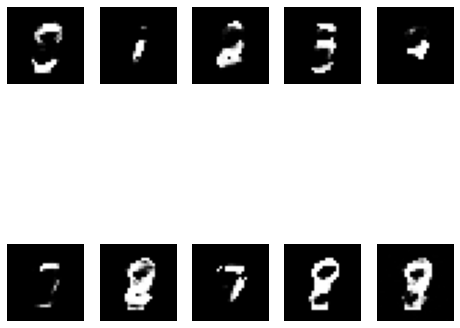

In [261]:
images2 = []

for i in range(10):
    with torch.no_grad():
        number = F.one_hot(torch.tensor([i]), num_classes=latent_dim)
        number *= 2
        number = torch.where(number == 0, torch.tensor(-0.25), number)
        number = number.to(torch.float)
        
        
        generated_image = autoencoder.decoder(number).view(28, 28).cpu().numpy()
        images2.append(generated_image)
        
plt.figure(figsize=(8, 8))
for i in range(10):
    plt.subplot(2, 5, i + 1) 
    plt.imshow(images2[i], cmap='gray')
    plt.axis('off')

plt.show()

In [279]:
torch.save(autoencoder.state_dict(), 'mein_modell.pth')
# autoencoder.load_state_dict(torch.load('mein_modell.pth'))

In [280]:
autoencoder.load_state_dict(torch.load('mein_modell.pth'))

<All keys matched successfully>